##### Inspired by: https://en.wikipedia.org/wiki/Tower_of_Hanoi  and https://en.wikipedia.org/wiki/Hanoi_graph

## Importing PWE and other essentials

In [1]:
from PW_explorer.run_clingo import run_clingo
from PW_explorer.load_worlds import load_worlds
import PW_explorer

## Generating the encoding

Here we generate a encoding parametrized by the number of disks and pegs. Such encoding generators can especially be helpful in planning scenarios where one might want to "activate" some rules in certain states, etc.

Set the number of disks and pegs

In [2]:
NUM_DISKS = 3
NUM_PEGS = 3

Generate the rules

In [3]:
toh_edge_rules = []

# Add the schema information for the 'peg' relation
toh_edge_rules.append('% define peg(PEG_ID)')

# Define the pegs as 'peg(a;b;c;...)'
toh_edge_rules.append('peg({}).'.format(';'.join([chr(ord('a')+i) for i in range(NUM_PEGS)])))

# Peg IDs for the disks i.e. [D1, D2, D3, ...]
start_state = ['D{}'.format(d+1) for d in range(NUM_DISKS)]

# Peg declaration for the disks i.e. ['peg(D1)', 'peg(D2)', 'peg(D3)', ...]
start_state_pegs = ['peg({})'.format(d) for d in start_state]

# Add schema information for the 'e' (edge) relation 
# i.e. % define e(DISK1_INIT_PEG, DISK2_INIT_PEG, ..., DISK1_END_PEG, DISK2_END_PEG, ...)
edge_init_col_names = ['DISK{}_INIT_PEG'.format(i) for i in range(1, NUM_DISKS+1)]
edge_end_col_names = ['DISK{}_END_PEG'.format(i) for i in range(1, NUM_DISKS+1)]
toh_edge_rules.append('% define e({},{})'.format(','.join(edge_init_col_names), 
                                                 ','.join(edge_end_col_names)))

# Create the rules that define if a disk i can be moved
for i in range(NUM_DISKS):
    
    # Create Peg IDs for the end state i.e. ['D1',.., 'D{i-1}', 'D{i}_', 'D{i+1}',...]
    end_state = ['D{}'.format(d+1) if d != i else 'D{}_'.format(d+1) for d in range(NUM_DISKS)]
    # Pegs for end state i.e. ['peg(D1)', ..., 'peg(D{i})', ....]
    end_state_pegs = ['peg({})'.format(d) for d in end_state]
    # Checks that D{i} is unblocked i.e. ['D{i} != D1', 'D{i} != D2', ..., 'D{i} != D{i-1}']
    unblocked_checks = ['{} != {}'.format(start_state[i], start_state[j]) for j in range(0, i)]
    # Checks that D{i} is moving to a peg where it would be the smallest disk
    # i.e. ['D{i}_ != D1', 'D{i}_ != D2', ..., 'D{i}_ != D{i-1}']
    valid_move_checks = ['{} != {}'.format(end_state[i], start_state[j]) for j in range(0, i)]
    # Check that the init and end states are different i.e. 'D{i} != D{i}_'
    uniqueness_check = '{} != {}'.format(start_state[i], end_state[i])
    # Create the rule for disk i
    toh_edge_rules.append('e({0},{1}) :- {2}, {3}, {4}{5}{6}.'
                          .format(','.join(start_state), ','.join(end_state),
                                  ','.join(start_state_pegs), end_state_pegs[i], 
                                  uniqueness_check,
                                  ', {}'.format(', '.join(unblocked_checks)) 
                                      if len(unblocked_checks) > 0 else '',
                                  ', {}'.format(', '.join(valid_move_checks)) 
                                      if len(valid_move_checks) > 0 else ''))



#### So we end up with these rules

In [4]:
print('\n'.join(toh_edge_rules))

% define peg(PEG_ID)
peg(a;b;c).
% define e(DISK1_INIT_PEG,DISK2_INIT_PEG,DISK3_INIT_PEG,DISK1_END_PEG,DISK2_END_PEG,DISK3_END_PEG)
e(D1,D2,D3,D1_,D2,D3) :- peg(D1),peg(D2),peg(D3), peg(D1_), D1 != D1_.
e(D1,D2,D3,D1,D2_,D3) :- peg(D1),peg(D2),peg(D3), peg(D2_), D2 != D2_, D2 != D1, D2_ != D1.
e(D1,D2,D3,D1,D2,D3_) :- peg(D1),peg(D2),peg(D3), peg(D3_), D3 != D3_, D3 != D1, D3 != D2, D3_ != D1, D3_ != D2.


#### Run these rules in clingo

In [5]:
clingo_soln, meta_data = run_clingo(clingo_rules=toh_edge_rules)
print('\n'.join(clingo_soln))

Answer: 1
peg(a) peg(b) peg(c) e(b,a,a,a,a,a) e(c,a,a,a,a,a) e(b,b,a,a,b,a) e(c,b,a,a,b,a) e(b,c,a,a,c,a) e(c,c,a,a,c,a) e(b,a,b,a,a,b) e(c,a,b,a,a,b) e(b,b,b,a,b,b) e(c,b,b,a,b,b) e(b,c,b,a,c,b) e(c,c,b,a,c,b) e(b,a,c,a,a,c) e(c,a,c,a,a,c) e(b,b,c,a,b,c) e(c,b,c,a,b,c) e(b,c,c,a,c,c) e(c,c,c,a,c,c) e(a,a,a,b,a,a) e(c,a,a,b,a,a) e(a,b,a,b,b,a) e(c,b,a,b,b,a) e(a,c,a,b,c,a) e(c,c,a,b,c,a) e(a,a,b,b,a,b) e(c,a,b,b,a,b) e(a,b,b,b,b,b) e(c,b,b,b,b,b) e(a,c,b,b,c,b) e(c,c,b,b,c,b) e(a,a,c,b,a,c) e(c,a,c,b,a,c) e(a,b,c,b,b,c) e(c,b,c,b,b,c) e(a,c,c,b,c,c) e(c,c,c,b,c,c) e(a,a,a,c,a,a) e(b,a,a,c,a,a) e(a,b,a,c,b,a) e(b,b,a,c,b,a) e(a,c,a,c,c,a) e(b,c,a,c,c,a) e(a,a,b,c,a,b) e(b,a,b,c,a,b) e(a,b,b,c,b,b) e(b,b,b,c,b,b) e(a,c,b,c,c,b) e(b,c,b,c,c,b) e(a,a,c,c,a,c) e(b,a,c,c,a,c) e(a,b,c,c,b,c) e(b,b,c,c,b,c) e(a,c,c,c,c,c) e(b,c,c,c,c,c) e(c,b,a,c,a,a) e(b,c,a,b,a,a) e(c,b,b,c,a,b) e(b,c,b,b,a,b) e(c,b,c,c,a,c) e(b,c,c,b,a,c) e(c,a,a,c,b,a) e(a,c,a,a,b,a) e(c,a,b,c,b,b) e(a,c,b,a,b,b) e(c,a,c,c

In [6]:
meta_data

{'attr_defs': {'peg_1': ['PEG_ID'],
  'e_6': ['DISK1_INIT_PEG',
   'DISK2_INIT_PEG',
   'DISK3_INIT_PEG',
   'DISK1_END_PEG',
   'DISK2_END_PEG',
   'DISK3_END_PEG']},
 'temporal_decs': {}}

#### Load this solution i.e. the set of edges into PWE

In [7]:
pw_rels_dfs, rel_schemas, pw_objs = load_worlds(asp_output=clingo_soln, meta_data=meta_data, reasoner='clingo')

Number of Models: 1


In [8]:
pw_rels_dfs.keys()

dict_keys(['peg_1', 'e_6'])

In [9]:
edge_rel_name = 'e_{}'.format(2*NUM_DISKS)
edge_rel_name

'e_6'

And here's the set of edges created

In [10]:
pw_rels_dfs[edge_rel_name]

,pw,DISK1_INIT_PEG,DISK2_INIT_PEG,DISK3_INIT_PEG,DISK1_END_PEG,DISK2_END_PEG,DISK3_END_PEG
0,1,b,a,a,a,a,a
1,1,c,a,a,a,a,a
2,1,b,b,a,a,b,a
3,1,c,b,a,a,b,a
4,1,b,c,a,a,c,a
5,1,c,c,a,a,c,a
6,1,b,a,b,a,a,b
7,1,c,a,b,a,a,b
8,1,b,b,b,a,b,b
9,1,c,b,b,a,b,b


### Converting this into a networkx graph
This is desirable since it allows for further analysis of the resulting graph

Some imports required like networkx

In [11]:
import networkx as nx
import matplotlib.pyplot as plt
from nxpd import draw
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'

Create the graph

In [12]:
G = nx.Graph()
edges = []
for i, row in pw_rels_dfs[edge_rel_name].iterrows():
    start_node = "{}".format(''.join([row[col] for col in edge_init_col_names]))
    end_node = "{}".format(''.join([row[col] for col in edge_end_col_names]))
    G.add_edge(start_node, end_node, penwidth=2)
    edges.append((start_node, end_node))
for node in G.nodes: G.nodes[node]['fontname'] = 'Helvetica'
G.graph['layout'] = 'neato'
G.graph['rankdir'] = 'TB'

Now let's visualize it!

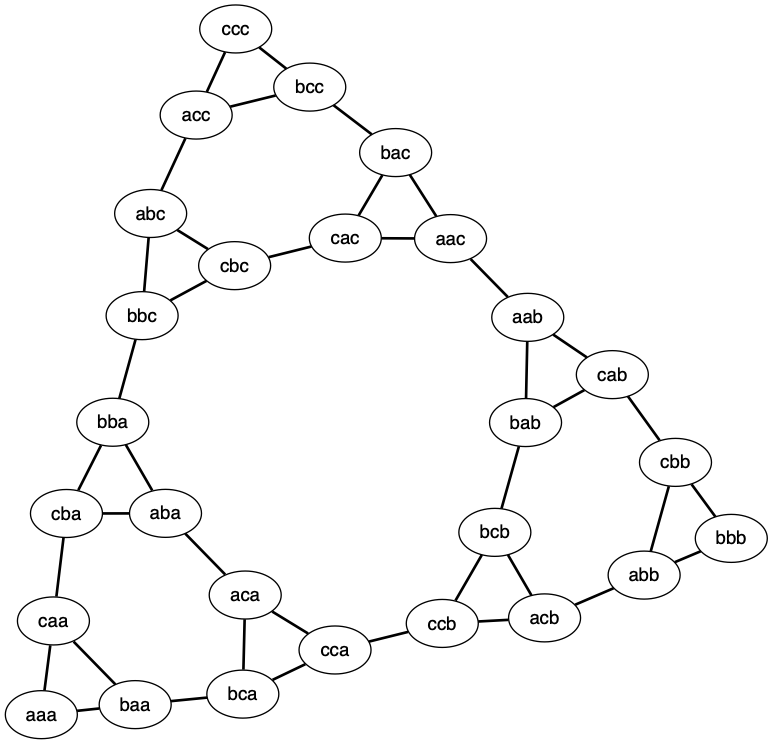

In [13]:
draw(G)

Since we now have a networkx representation of this graph, we can conduct some cool analysis such as finding the shortest path between the start (aaa..) and end state (ccc...) of a TOH game.

In [14]:
path = list(nx.shortest_path(G, 'a'*NUM_DISKS, chr(ord('a')+NUM_PEGS-1)*NUM_DISKS))
print(' --> '.join(path))

aaa --> caa --> cba --> bba --> bbc --> abc --> acc --> ccc


In [15]:
path_edges = list(zip(path, path[1:]))

We can now visualize and highlight this path

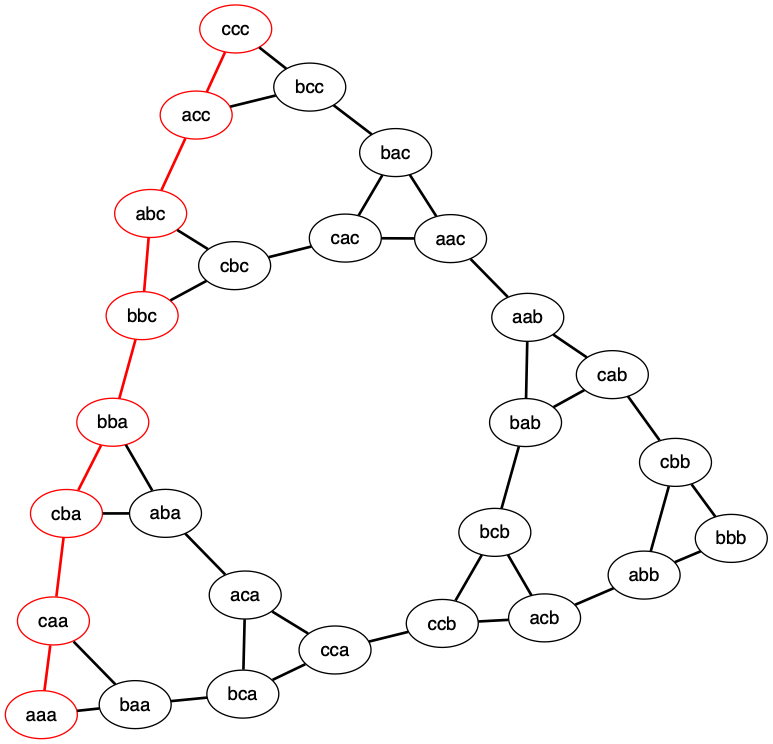

In [16]:
for node in path:
    G.nodes[node]['color'] = 'red'
for edge in path_edges:
    G.edges[edge]['color'] = 'red'
draw(G)

In [17]:
# To save the above visualization:
# for f in ['png', 'pdf', 'svg', 'dot']:
#     draw(G, format=f, filename='hanoi_graph.{}'.format(f), show='none')